## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

More information on this classification method can be found at
https://arxiv.org/abs/1602.04105

More information on the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Please cite derivative works

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

To run this example, you will need to download or generate the RML2016.10a dataset (https://radioml.com/datasets/)
You will also need Keras installed with either the Theano or Tensor Flow backend working.

Have fun!

In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Permute,Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, Conv1D, MaxPooling2D, ZeroPadding2D, ZeroPadding1D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
#import seaborn as sns
import cPickle, random, sys, keras
#import h5py as h5py

Using TensorFlow backend.


# Test the datapoints to see if they're OK

(128, 128)
[{'width': 85, 'height': 102, 'center': (42, 51), 'label': 'QAM16'}]


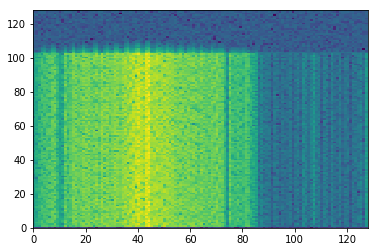

In [2]:
import matplotlib.pyplot as plt
import os

#path = "trainingdataset/"
path1 = "objects/"
path2 = "test_objects/"

datapoint = cPickle.load(open(os.path.join(path2,'object_generated0.dat')))

print datapoint['data'][:,:,0].shape
print datapoint['objects']
#t = datapoint['segment_t']
#f = datapoint['sample_f']
#x = 1024
#y = 293
#plt.pcolormesh(t, f, datapoint['data'][:,:,0])
plt.pcolormesh(np.log((datapoint['data'][:,:,0] ** 2 + datapoint['data'][:,:,1] ** 2) ** .5))
#print datapoint['center']

# Create the dataset using generator

In [3]:
from dataset.dataset_model import dataset_model

# Set up some params
nb_epoch = 100     # number of epochs to train on
batch_size = 32  # training batch size

train_set = dataset_model('objects/')
test_set = dataset_model('test_objects/')


train_set_gen = train_set.dataset_generator(batch_size)
test_set_gen = test_set.dataset_generator(batch_size)

num_classes = len(train_set.class_types)


We also want to see how well we can classify on Fourier transforms of the signal. This will provide a clue as to how well it will work on Spectograms. 

## Let's try the Darknet Reference Model

The Darknet Reference Model is commonly used in conjunction with the YOLO object detection methodology. It is significantly faster than GoogLeNet v1, which will be important for us. 

In [4]:
dr = 0.5
conv_size = (3,3)
model = models.Sequential()
model.add(Conv2D(16, conv_size, padding="same", strides=(1, 1), input_shape=(128, 128,2), name='conv1'))
#model.add(BatchNormalization(name='batchnorm1')) # We don't add any axis as last is correct 
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, conv_size, padding="same", name='conv2'))
#model.add(BatchNormalization(name='batchnorm2'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

model.add(Conv2D(64, conv_size, padding="same", name='conv3'))
#model.add(BatchNormalization(name='batchnorm3'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

model.add(Conv2D(128, conv_size, padding="same", name='conv4'))
#model.add(BatchNormalization(name='batchnorm4'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

model.add(Conv2D(256, conv_size, padding="same", name='conv5'))
#model.add(BatchNormalization(name='batchnorm5'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

model.add(Conv2D(512, conv_size, padding="same", name='conv6'))
#model.add(BatchNormalization(name='batchnorm6'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

model.add(Conv2D(1024, conv_size, padding="same", name='conv7'))
#model.add(BatchNormalization(name='batchnorm7'))
model.add(LeakyReLU(alpha=0.1))

model.add(Conv2D(num_classes, conv_size, padding="same", name='conv8'))
model.add(GlobalAveragePooling2D())

model.add(Activation('softmax'))
model.add(Reshape([num_classes]))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 128, 128, 16)      304       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 32, 64)        18496     
__________

# Train the Model

In [5]:

#%%capture output
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'spectrumCNN.wts.h5'
history = model.fit_generator(generator = train_set_gen,
    steps_per_epoch=int(11000/batch_size),
    epochs=nb_epoch,
    verbose=2,
    validation_data = test_set_gen,
    validation_steps = 100,
    pickle_safe = True,
    workers = 4,                                        
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
73s - loss: 1.0048 - acc: 0.5569 - val_loss: 0.5910 - val_acc: 0.7941
Epoch 2/100
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
71s - loss: 0.3441 - acc: 0.8239 - val_loss: 0.3220 - val_acc: 0.8003
Epoch 3/100
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached en

Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
69s - loss: 0.2575 - acc: 0.8945 - val_loss: 0.3149 - val_acc: 0.8475
Epoch 19/100
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
70s - loss: 0.2461 - acc: 0.8923 - val_loss: 0.2702 - val_acc: 0.8712
Epoch 20/100
Reached end of Set 1, reshuffling...
Reached end of Set 1, reshuffling...
Reached end of Set 1

In [25]:
import config
print config.CLASS_TYPES
test = cPickle.load(file('test_objects/object_generated20.dat'))
p = model.predict(np.array([test['data']]))
print p
print(test['objects'])

['QAM4', 'QAM16', 'QAM64', 'QAM256', 'PSK2', 'PSK4', 'PSK8', 'PSK16']
[[ 0.  0.  0.  0.  0.  0.  0.  1.]]
[{'width': 85, 'height': 117, 'center': (55, 58), 'label': 'PSK16'}]


In [3]:
# test = cPickle.load(file('trainingdataset/object_generated12.dat'))
# p = model.predict(np.array([test['data']]))
# print p
# print(test['objects'])
datapoints_copy = list(train_set.datapoints)
batch_labels = [train_set.class_types.index(point['label']) for point in datapoints_copy[0:32]]
print batch_labels
batch_labels_onehot = train_set.to_onehot(batch_labels)
print batch_labels_onehot

[0, 3, 0, 5, 6, 1, 1, 5, 3, 0, 4, 3, 1, 3, 1, 5, 7, 1, 1, 0, 6, 2, 4, 4, 1, 4, 0, 7, 3, 4, 0, 0]
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0

# Evaluate and Plot Model Performance

In [49]:
test = next(test_set_gen)
X_test = test[0]
Y_test = test[1]
p = model.predict(X_test)
print(np.argmax(p, axis=1))
print(np.argmax(Y_test, axis=1))
print Y_test
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print score

[6 3 0 1 6 6 2 2 3 7 6 7 0 1 3 0 7 3 4 2 0 7 0 2 2 5 1 4 2 0 0 7]
[6 3 0 1 6 6 2 2 3 7 6 7 0 1 3 5 7 3 4 2 0 7 0 2 2 0 1 4 2 0 0 7]
[[ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0

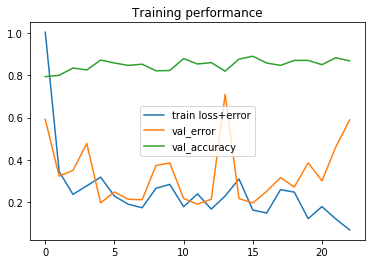

In [32]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.plot(history.epoch, history.history['val_acc'], label='val_accuracy')
plt.legend()

In [50]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

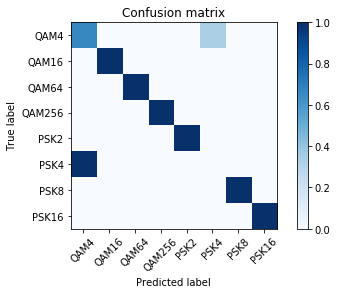

In [63]:
# Plot confusion matrix
classes = config.CLASS_TYPES
test = next(test_set_gen)
X_test = test[0]
Y_test = test[1]
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



In [53]:
# Plot confusion matrix
acc = {}
for snr in snrs:
    print snr

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print "Overall Accuracy: ", cor / (cor+ncor)
    acc[snr] = 1.0*cor/(cor+ncor)
    

NameError: name 'snrs' is not defined

In [54]:
# Save results to a pickle file for plotting later
print acc
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{}


In [55]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")

NameError: name 'snrs' is not defined